In [14]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score,mean_squared_error
import category_encoders as ce
import time
import pickle
import gc
RSEED = 47

%matplotlib inline

# Load Data

In [15]:
with open('./data/df_train_total_feat.pickle', 'rb') as handle:
    df_train_total = pickle.load(handle)
    
with open('./data/df_test_total_feat.pickle', 'rb') as handle:
    df_test_total = pickle.load(handle)

In [16]:
df_train_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0


In [17]:
df_test_total.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,0,2017-01-01,0,0,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
1,1,1,0,2017-01-01,0,0,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
2,2,2,0,2017-01-01,0,0,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
3,3,3,0,2017-01-01,0,0,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0
4,4,4,0,2017-01-01,0,0,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0


# Remove Strange Data

In [18]:
df_train_total = df_train_total.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Add Feature

In [37]:
# change year built
df_train_total["year_built"] = df_train_total["timestamp"].dt.year - df_train_total["year_built"]
df_test_total["year_built"] = df_test_total["timestamp"].dt.year - df_test_total["year_built"]

In [27]:
# add weekday feature
# 3fold improve ele reduce others
#df_train_total["weekday"] = df_train_total["timestamp"].dt.weekday
#df_test_total["weekday"] = df_test_total["timestamp"].dt.weekday

In [28]:
#df_train_total["month"] = df_train_total["timestamp"].dt.month
#df_test_total["month"] = df_test_total["timestamp"].dt.month

In [140]:
# add target encoding feature
#df_group = df_train_total.groupby(['building_id','meter'])['meter_reading']
#building_median = df_group.median().astype(np.float16).to_frame().reset_index()
#df_train_total['building_median'] = df_train_total.groupby(['building_id','meter'])['meter_reading'].transform('median')
#df_test_total['building_median'] = pd.merge(df_test_total,building_median,on=['building_id','meter'],how='left')['meter_reading']

In [55]:
# log transform square feet
#df_train_total["square_feet"] = np.log(df_train_total["square_feet"])
#df_test_total["square_feet"] = np.log(df_test_total["square_feet"])

In [29]:
# drop useless feature
#df_train_total.drop(["timestamp"],inplace = True,axis=1)
#df_test_total.drop(["timestamp"],inplace = True,axis=1)

# Train with Seperate Meter Type

## General Settings

In [38]:
params = {'objective':'regression',
          'boosting_type':'gbdt',
          'metric':'rmse',
          'learning_rate':0.1,
          'num_leaves': 2**8,
          'max_depth':-1,
          'colsample_bytree':0.5,# feature_fraction 0.7
          'subsample_freq':1,
          'subsample':0.7,
          'verbose':-1,
          'num_threads':8,
          'seed': 47,#42
                } 

In [39]:
category_cols = ['building_id', 'site_id', 'primary_use','hour'] #,'weekday','month'
category_cols

['building_id', 'site_id', 'primary_use', 'hour']

In [40]:
def fold_train_model(splits_num,features_train,labels_train,features_test,categorical):
    splits = splits_num
    folds = KFold(n_splits = splits,random_state=50)
    #folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=50)
    predictions = np.zeros(len(features_test))
    models = []
    ave_score = 0
    
    for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, labels_train.values)):
    #for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, features_train['building_id'])):
        print("Fold {}".format(fold_num))
        train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
        valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]

        trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
        val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)

        valid_results = {}
        clf = lgb.train(params,
                        trn_data,
                        2000,#10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=50,
                        early_stopping_rounds=200,
                        evals_result=valid_results)

        #pred = clf.predict(valid_df)
        score = min(valid_results['valid_1']['rmse'])#np.sqrt(mean_squared_error(y_valid_df, pred))
        print(score)
        ave_score += score / splits
        predictions += np.expm1(clf.predict(features_test)) / splits
        models.append(clf)
    return ave_score,predictions,models

In [41]:
def train_meter_type(meter_type,df_train_total,df_test_total,category_cols,splits_num):
    # prepare data
    df_type_train = df_train_total[df_train_total.meter == meter_type]
    df_type_label = df_type_train['meter_reading']
    #df_type_label = np.log1p(df_type_train['meter_reading'])
    df_type_train.drop(columns = ['meter','meter_reading'],inplace=True)
    df_type_train['timestamp'] = df_type_train['timestamp'].astype('int64') // 10**9

    df_type_test = df_test_total[df_test_total.meter == meter_type]
    df_type_row_id = df_type_test['row_id']
    df_type_test.drop(columns = ['row_id','meter'],inplace=True)
    df_type_test['timestamp'] = df_type_test['timestamp'].astype('int64') // 10**9
    
    # train model
    print('train model')
    ave_score,predictions_type,models = fold_train_model(splits_num,df_type_train,df_type_label,df_type_test,category_cols)
    print('ave socre is %s'%(ave_score))
    
    # get prediction
    print('get prediction')
    sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': predictions_type})
    #sub_type = pd.DataFrame({'row_id': df_type_row_id, 'meter_reading': np.expm1(predictions_type)})
    return sub_type,ave_score,models

## Train electricity

In [42]:
sub_ele_f,ave_score_ele,model_ele = train_meter_type(0,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.434962	valid_1's rmse: 0.609319
[100]	training's rmse: 0.353886	valid_1's rmse: 0.592371
[150]	training's rmse: 0.325371	valid_1's rmse: 0.595515
[200]	training's rmse: 0.310072	valid_1's rmse: 0.594929
[250]	training's rmse: 0.293914	valid_1's rmse: 0.593601
Early stopping, best iteration is:
[97]	training's rmse: 0.357054	valid_1's rmse: 0.59192
0.5919195402901072
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.427634	valid_1's rmse: 0.67198
[100]	training's rmse: 0.341492	valid_1's rmse: 0.650305
[150]	training's rmse: 0.313721	valid_1's rmse: 0.645136
[200]	training's rmse: 0.296733	valid_1's rmse: 0.640581
[250]	training's rmse: 0.282899	valid_1's rmse: 0.638097
[300]	training's rmse: 0.273299	valid_1's rmse: 0.63661
[350]	training's rmse: 0.265655	valid_1's rmse: 0.635925
[400]	training's rmse: 0.259495	valid_1's rmse: 0.6347
[450]	training's rmse: 0.25414	valid_1's rmse: 0.634892
[500]	training's rmse: 0.249912	valid_1's rmse: 0.634517
[550]	training's rmse: 0.246233	valid_1's rmse: 0.633581
[600]	training's rmse: 0.242397	valid_1's rmse: 0.633451
[650]	training's rmse: 0.238912	valid_1's rmse: 0.632584
[700]	training's rmse: 0.236432	valid_1's rmse: 0.632464
[750]	training's rmse: 0.234267	valid_1's rmse: 0.632427
[800]	training's rmse: 0.232223	valid_1's rmse: 0.632547
[850]	training's rmse: 0.229994

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.425513	valid_1's rmse: 0.677803
[100]	training's rmse: 0.352274	valid_1's rmse: 0.670543
[150]	training's rmse: 0.322725	valid_1's rmse: 0.676684
[200]	training's rmse: 0.308007	valid_1's rmse: 0.678742
[250]	training's rmse: 0.294692	valid_1's rmse: 0.68429
Early stopping, best iteration is:
[91]	training's rmse: 0.362539	valid_1's rmse: 0.66582
0.6658196339670175
ave socre is 0.6300062745944971
get prediction


In [43]:
ave_score_ele

0.6300062745944971

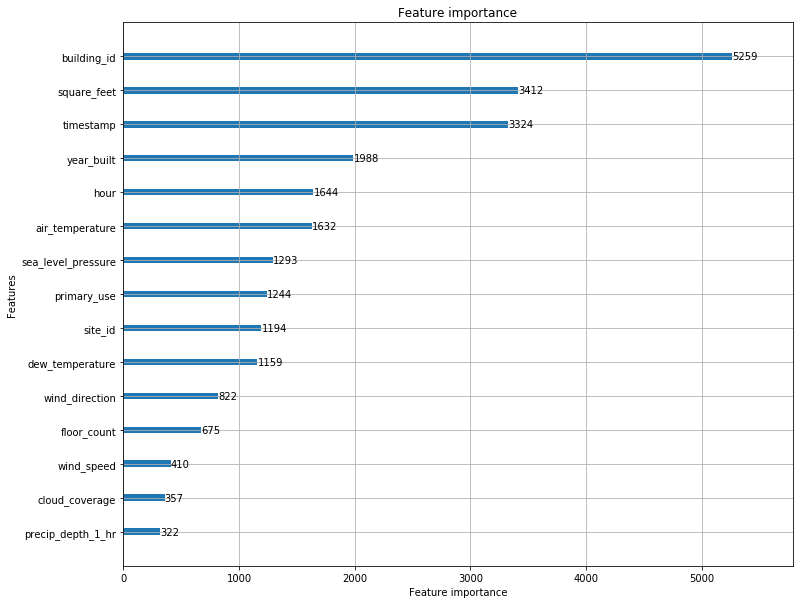

In [44]:
lgb.plot_importance(model_ele[0], max_num_features=20,figsize=(12,10))

In [45]:
sub_cw_f,ave_score_cw,model_cw = train_meter_type(1,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.933333	valid_1's rmse: 1.41579
[100]	training's rmse: 0.79774	valid_1's rmse: 1.38171
[150]	training's rmse: 0.749142	valid_1's rmse: 1.37907
[200]	training's rmse: 0.717544	valid_1's rmse: 1.37633
[250]	training's rmse: 0.685694	valid_1's rmse: 1.37603
[300]	training's rmse: 0.65869	valid_1's rmse: 1.37292
[350]	training's rmse: 0.640122	valid_1's rmse: 1.37181
[400]	training's rmse: 0.625915	valid_1's rmse: 1.37252
[450]	training's rmse: 0.612305	valid_1's rmse: 1.37466
[500]	training's rmse: 0.602293	valid_1's rmse: 1.38109
Early stopping, best iteration is:
[337]	training's rmse: 0.643877	valid_1's rmse: 1.36982
1.369815431985976
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.945637	valid_1's rmse: 1.3944
[100]	training's rmse: 0.816206	valid_1's rmse: 1.37319
[150]	training's rmse: 0.760491	valid_1's rmse: 1.37551
[200]	training's rmse: 0.729581	valid_1's rmse: 1.37399
[250]	training's rmse: 0.69923	valid_1's rmse: 1.37546
Early stopping, best iteration is:
[87]	training's rmse: 0.840155	valid_1's rmse: 1.3686
1.368599931995163
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.893381	valid_1's rmse: 1.52579
[100]	training's rmse: 0.772514	valid_1's rmse: 1.51439
[150]	training's rmse: 0.727975	valid_1's rmse: 1.52041
[200]	training's rmse: 0.698113	valid_1's rmse: 1.5306
[250]	training's rmse: 0.669867	valid_1's rmse: 1.53984
Early stopping, best iteration is:
[87]	training's rmse: 0.797144	valid_1's rmse: 1.50289
1.5028910484661502
ave socre is 1.4137688041490963
get prediction


In [28]:
ave_score_cw

1.4194281629138206

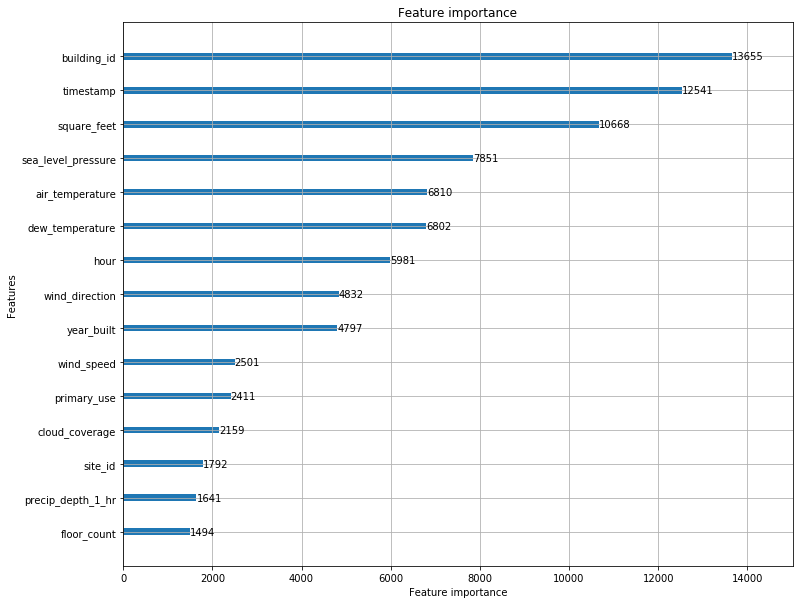

In [46]:
lgb.plot_importance(model_cw[0], max_num_features=20,figsize=(12,10))

In [47]:
sub_stm_f,ave_score_stm,model_stm = train_meter_type(2,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 1.01776	valid_1's rmse: 1.4936
[100]	training's rmse: 0.916193	valid_1's rmse: 1.47297
[150]	training's rmse: 0.879334	valid_1's rmse: 1.47606
[200]	training's rmse: 0.855675	valid_1's rmse: 1.48094
[250]	training's rmse: 0.835815	valid_1's rmse: 1.48641
Early stopping, best iteration is:
[98]	training's rmse: 0.920364	valid_1's rmse: 1.4718
1.4718043782594836
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.98479	valid_1's rmse: 1.48106
[100]	training's rmse: 0.862026	valid_1's rmse: 1.44439
[150]	training's rmse: 0.818243	valid_1's rmse: 1.43751
[200]	training's rmse: 0.79168	valid_1's rmse: 1.43452
[250]	training's rmse: 0.767239	valid_1's rmse: 1.43155
[300]	training's rmse: 0.747628	valid_1's rmse: 1.43165
[350]	training's rmse: 0.734012	valid_1's rmse: 1.43066
[400]	training's rmse: 0.721259	valid_1's rmse: 1.42972
[450]	training's rmse: 0.710681	valid_1's rmse: 1.42828
[500]	training's rmse: 0.702168	valid_1's rmse: 1.42877
[550]	training's rmse: 0.6939	valid_1's rmse: 1.42841
[600]	training's rmse: 0.685554	valid_1's rmse: 1.42891
Early stopping, best iteration is:
[446]	training's rmse: 0.711865	valid_1's rmse: 1.4282
1.4281965598813644
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 1.00555	valid_1's rmse: 1.54752
[100]	training's rmse: 0.907763	valid_1's rmse: 1.56339
[150]	training's rmse: 0.871295	valid_1's rmse: 1.56947
[200]	training's rmse: 0.84683	valid_1's rmse: 1.5684
Early stopping, best iteration is:
[48]	training's rmse: 1.00928	valid_1's rmse: 1.54688
1.5468761068826535
ave socre is 1.4822923483411672
get prediction


In [48]:
ave_score_stm

1.4822923483411672

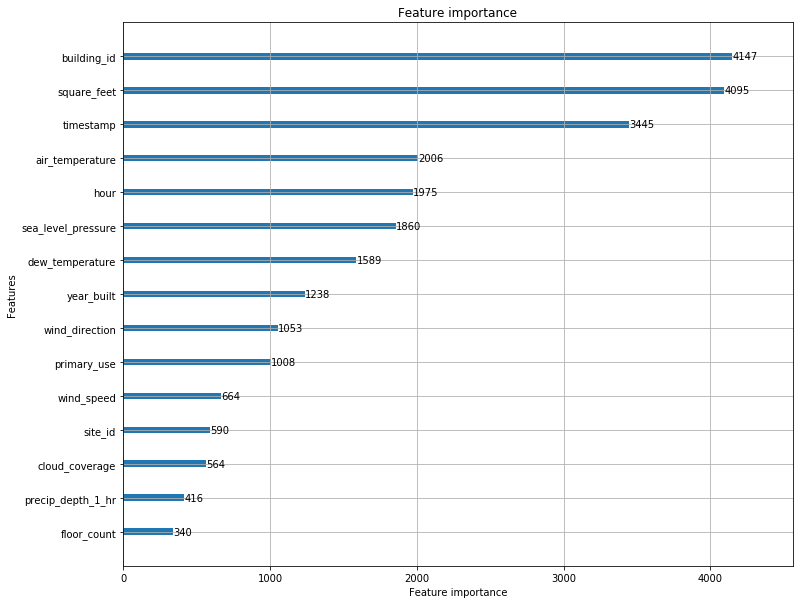

In [49]:
lgb.plot_importance(model_stm[0], max_num_features=20,figsize=(12,10))

In [ ]:
sub_hw_f,ave_score_hw,model_hw = train_meter_type(3,df_train_total,df_test_total,category_cols,3)

train model
Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 1.05374	valid_1's rmse: 1.715
[100]	training's rmse: 0.966571	valid_1's rmse: 1.74088
[150]	training's rmse: 0.925481	valid_1's rmse: 1.76579


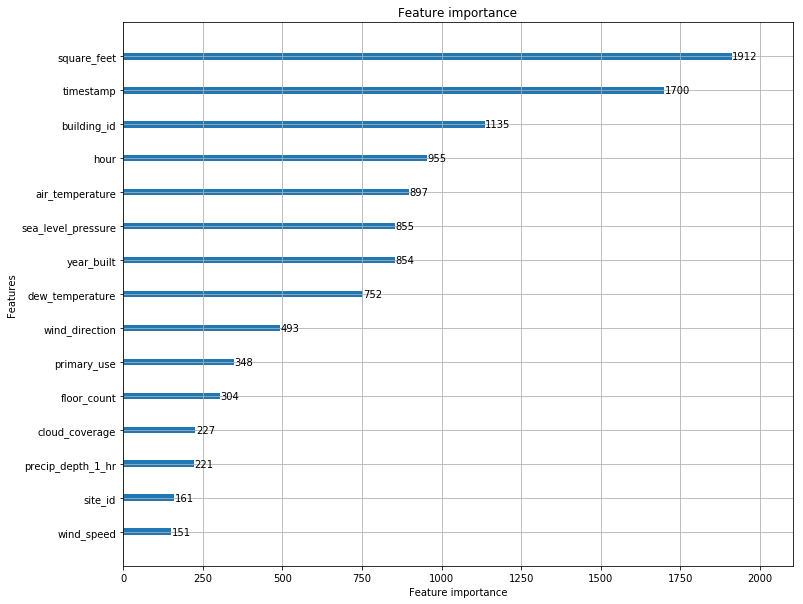

In [34]:
lgb.plot_importance(model_hw[0], max_num_features=20,figsize=(12,10))

In [36]:
# remove strange data and add hour feature
(ave_score_ele + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.284611467748853

In [60]:
# del timestamp hour weekday month as numerical
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2987565106027472

In [114]:
# del timestamp hour weekday month as category
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2984196921758442

In [189]:
# weekday in ele
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.27902318009362

In [180]:
# hour as category
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.2826695491418274

In [153]:
# add building median feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.3293813224155269

In [43]:
# five fold
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.1793592428754274

In [65]:
# hour + log square feet feature
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.306757096342972

In [51]:
# rmse
(ave_score + ave_score_cw + ave_score_stm + ave_score_hw) / 4

1.352893197767166

In [115]:
sub_all = pd.concat([sub_ele_f,sub_cw_f,sub_stm_f,sub_hw_f])
sub_all.sort_values(by='row_id')

,row_id,meter_reading
0,0,132.878041
1,1,75.271329
2,2,11.846371
3,3,263.274778
4,4,809.734215
...,...,...
41697595,41697595,6.808141
41697596,41697596,4.751617
41697597,41697597,3.698111
41697598,41697598,157.569475


In [47]:
sub_all.loc[sub_all.meter_reading < 0, 'meter_reading'] = 0

In [116]:
sub_all.to_csv('./data/baseline_delts_cate.csv', index = False)

In [27]:
#del sub_all
#gc.collect()

76